In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
import warnings

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [2]:
# Initialize lists
images = []
labels = []
# Set the base directory
base_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
# Walk through the directory tree
for root, dirs, files in tqdm(os.walk(base_dir)):
    for file in files:
        # Construct the full image path
        image_path = os.path.join(root, file)
        # Extract the label from the parent folder name
        label = os.path.basename(os.path.dirname(image_path))
        # Append image path and label to respective lists
        images.append(image_path)
        labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({'image': images, 'label': labels})
# Add space between capitalized words in the 'label' column
df['label'] = df['label'].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)
df

11it [00:01,  7.13it/s]


,image,label
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,Moderate Demented
...,...,...
6395,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented
6396,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented
6397,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented
6398,/kaggle/input/alzheimers-dataset-4-class-of-im...,Mild Demented


<Axes: ylabel='count'>

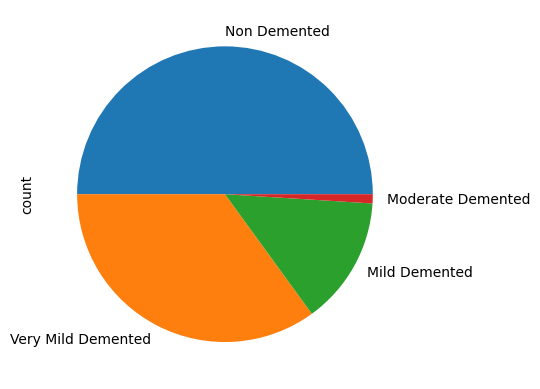

In [3]:
df.label.value_counts().plot(kind='pie')

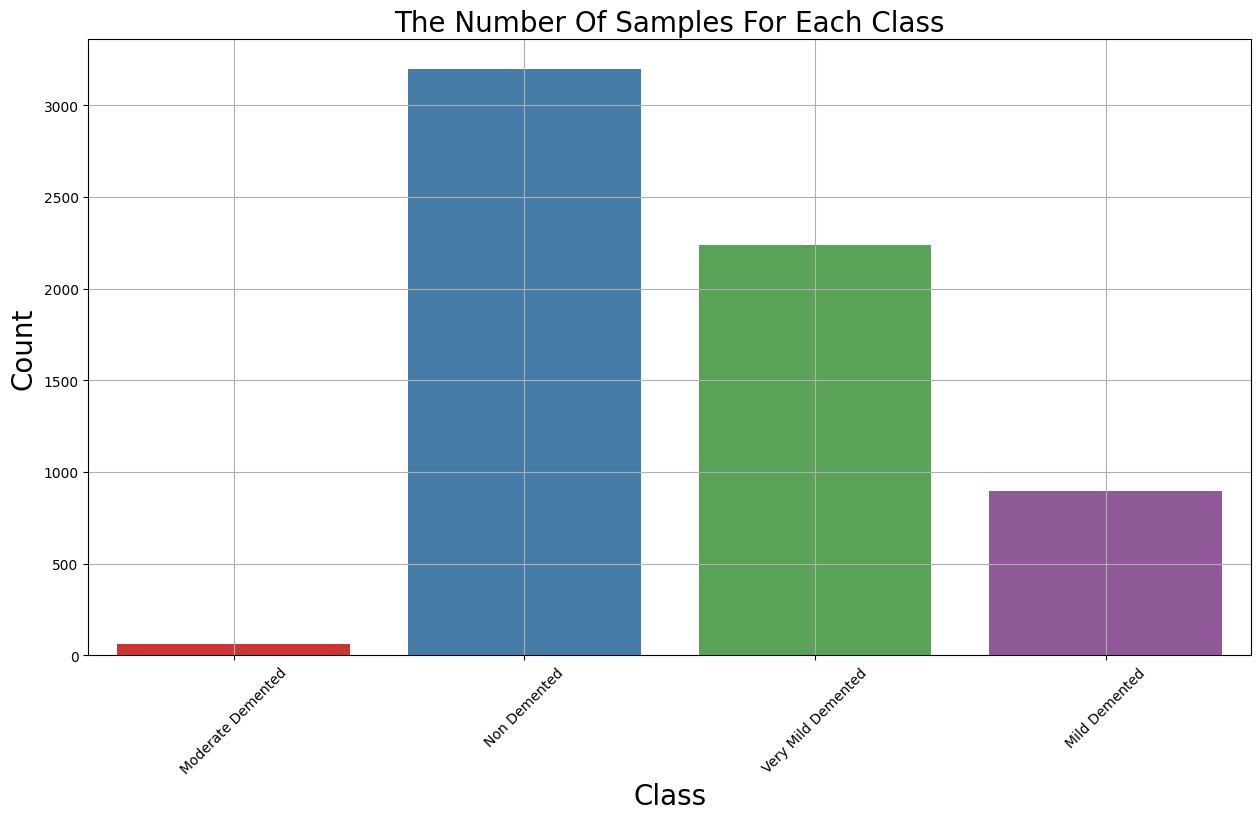

In [4]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [5]:
Size=(128,128)
gen = ImageDataGenerator(
    rescale = 1./255
)
train_gen = gen.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6400, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [6]:
train_data, train_labels = next(train_gen)
print(train_data.shape, train_labels.shape)

(6400, 128, 128, 3) (6400, 4)


In [7]:
class_num=np.sort(['Mild Demented','Moderate Demented','Non Demented','Very Mild Demented'])
class_num

array(['Mild Demented', 'Moderate Demented', 'Non Demented',
       'Very Mild Demented'], dtype='<U18')

## Generating Data

In [8]:
# Step 1: First, split the data into training, validation, and test sets before any augmentation
X_train, X_test1, y_train, y_test1 = train_test_split(train_data, train_labels, test_size=0.3, random_state=42, shuffle=True, stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)

# Flatten the training data for SMOTE application
sm = SMOTE(random_state=42)
X_train_flat, y_train = sm.fit_resample(X_train.reshape(-1, 128 * 128 * 3), y_train)

# Reshape the augmented training data back to the original image dimensions
X_train = X_train_flat.reshape(-1, 128, 128, 3)

# Output the shapes to check
print('X_train shape is ', X_train.shape)
print('X_test shape is ', X_test.shape)
print('X_val shape is ', X_val.shape)
print('y_train shape is ', y_train.shape)
print('y_test shape is ', y_test.shape)
print('y_val shape is ', y_val.shape)


X_train shape is  (8960, 128, 128, 3)
X_test shape is  (960, 128, 128, 3)
X_val shape is  (960, 128, 128, 3)
y_train shape is  (8960, 4)
y_test shape is  (960, 4)
y_val shape is  (960, 4)


## VGG16

In [ ]:
# Load pre-trained VGG16 model + higher-level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Adjust to the number of classes in your datase

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[model_checkpoint, early_stopping,reduce_lr])

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_.tail()

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy')
plt.legend()
plt.show()

In [ ]:
score, acc= model.evaluate(X_test,y_test)
print(f"Test Loss = {score:0.4f}")
print(f"Test Accuracy = {acc:0.1%}")

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test,axis=1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust figure size for better visualization
plt.figure(figsize=(30, 10))

# Randomly select 10 unique samples
indices = np.random.choice(len(X_test), 10, replace=False)

# Loop through selected samples and plot
for n, i in enumerate(indices):
    plt.subplot(2, 5, n + 1)  # 2 rows, 5 columns grid
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} : {class_num[y_pred_classes[i]]}',fontsize=15)
    
plt.tight_layout()
plt.show()


In [ ]:
CM = confusion_matrix(y_test_,y_pred_classes)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_,y_pred_classes)
print('Classification Report is : ', ClassificationReport )

# Transformers Based Models : ViT (vit-base-patch16-224)

In [9]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
feature_extractor = ViTFeatureExtractor.from_pretrained(
    'google/vit-base-patch16-224',
    do_rescale=False
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [10]:
def preprocess_images(images):
    return feature_extractor(images, return_tensors="pt")

In [11]:
X_train = preprocess_images(X_train)
print("train preprocessing has been finished")
X_val = preprocess_images(X_val)
print("validation preprocessing has been finished")
X_test = preprocess_images(X_test)
print("test preprocessing has been finished")

train preprocessing has been finished
validation preprocessing has been finished
test preprocessing has been finished


In [12]:
print(X_train['pixel_values'].shape)
print(X_val['pixel_values'].shape)
print(X_test['pixel_values'].shape)

torch.Size([8960, 3, 224, 224])
torch.Size([960, 3, 224, 224])
torch.Size([960, 3, 224, 224])


In [13]:
y_train = torch.tensor(y_train)  
y_val = torch.tensor(y_val)    
y_test = torch.tensor(y_test)

y_train = torch.argmax(y_train, dim=1)
y_test = torch.argmax(y_test, dim=1)
y_val = torch.argmax(y_val, dim=1)



In [14]:
print(y_train.shape)

torch.Size([8960])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_train = TensorDataset(X_train['pixel_values'], y_train)
X_val = TensorDataset(X_val['pixel_values'], y_val)
X_test = TensorDataset(X_test['pixel_values'], y_test)

train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
val_loader = DataLoader(X_val, batch_size=32)
test_loader = DataLoader(X_test, batch_size=32)

In [17]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device) 
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = loss_fn(outputs.logits, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)
    
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validating the Model
    model.eval()
    
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs.logits, labels)
            running_val_loss += loss.item()
            
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/10: 100%|██████████| 280/280 [02:45<00:00,  1.70it/s]


Epoch 1/10
Train Loss: 0.6246, Train Accuracy: 74.97%
Val Loss: 0.4795, Val Accuracy: 77.71%


Epoch 2/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 2/10
Train Loss: 0.1470, Train Accuracy: 94.39%
Val Loss: 0.1887, Val Accuracy: 92.60%


Epoch 3/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 3/10
Train Loss: 0.0713, Train Accuracy: 97.25%
Val Loss: 0.2111, Val Accuracy: 93.33%


Epoch 4/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 4/10
Train Loss: 0.0194, Train Accuracy: 99.50%
Val Loss: 0.1231, Val Accuracy: 96.15%


Epoch 5/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 5/10
Train Loss: 0.0199, Train Accuracy: 99.41%
Val Loss: 0.3840, Val Accuracy: 88.02%


Epoch 6/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 6/10
Train Loss: 0.0167, Train Accuracy: 99.44%
Val Loss: 0.0987, Val Accuracy: 96.88%


Epoch 7/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 7/10
Train Loss: 0.0004, Train Accuracy: 100.00%
Val Loss: 0.0677, Val Accuracy: 97.92%


Epoch 8/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 8/10
Train Loss: 0.0002, Train Accuracy: 100.00%
Val Loss: 0.0720, Val Accuracy: 97.81%


Epoch 9/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 9/10
Train Loss: 0.0002, Train Accuracy: 100.00%
Val Loss: 0.0722, Val Accuracy: 98.02%


Epoch 10/10: 100%|██████████| 280/280 [02:44<00:00,  1.70it/s]


Epoch 10/10
Train Loss: 0.0001, Train Accuracy: 100.00%
Val Loss: 0.0728, Val Accuracy: 98.02%


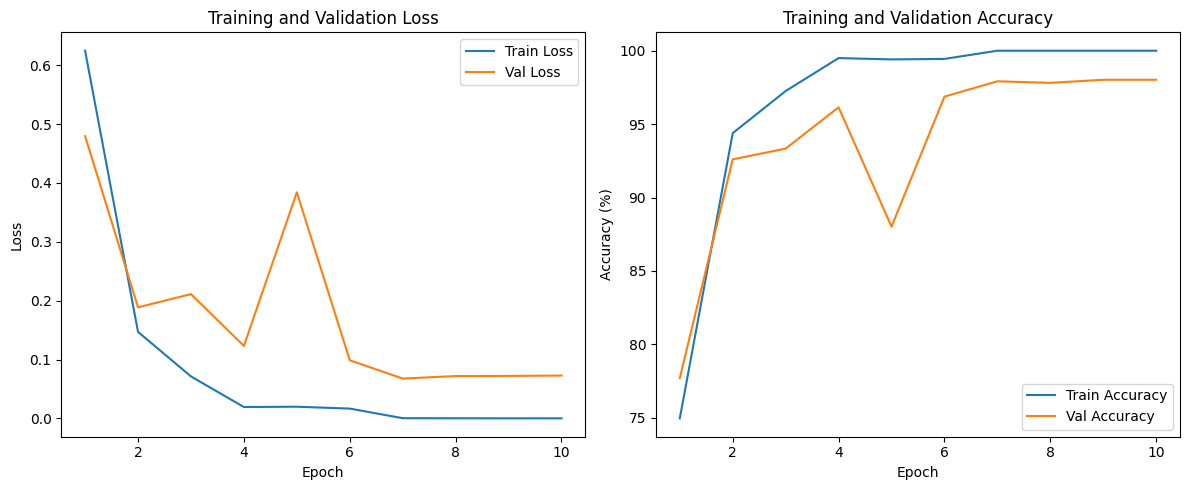

In [18]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in train_accuracies], label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), [acc * 100 for acc in val_accuracies], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 95.10%


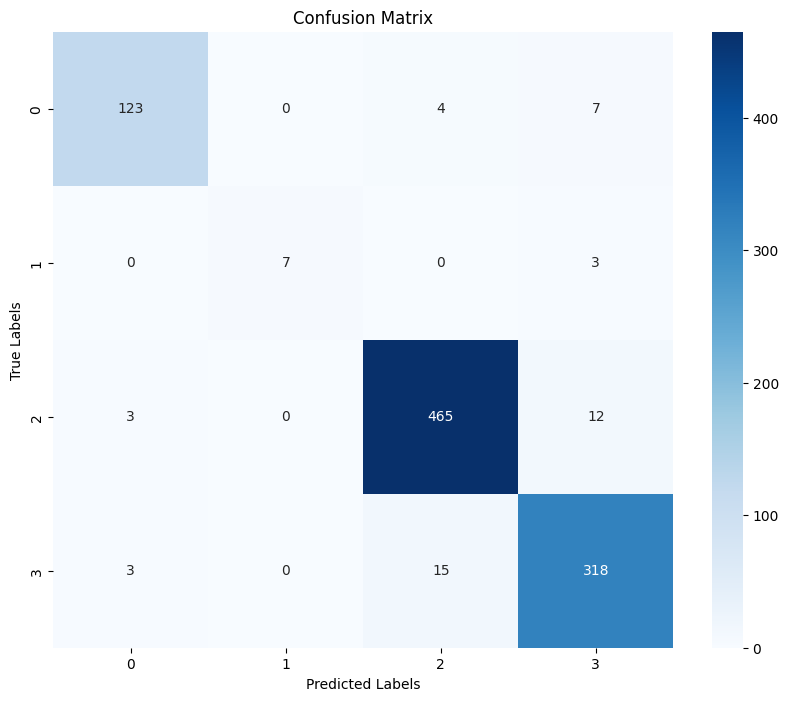

In [19]:
model.eval()

correct = 0
total = 0

all_labels = []
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)   
        outputs = model(inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())


test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save_pretrained('./fine-tuned-vit')